### dataset


> @inproceedings{silva2020study,
  title={A study on tooth segmentation and numbering using end-to-end deep neural networks},
  author={Silva, Bernardo and Pinheiro, Laís and Oliveira, Luciano and Pithon, Matheus}
  booktitle={Conference on Graphics, Patterns and Images (SIBGRAPI)},
  year={2020},
  organization={IEEE}
}

In [ ]:
IMG_PATH = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds'

IMG_PATH1 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold1/images'
IMG_PATH2 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold2/images'
IMG_PATH3 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold3/images'
IMG_PATH4 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold4/images'
IMG_TARGET = './drive/MyDrive/binary_masks/'

IMG_PATH5 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold5/images'
JSON_FILEPATH = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/complete-json/dns-panoramic-images.json'

IMG_PATH_BINARY = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation'
IMG_PATH6 = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation/images'
IMG_PATH6_TARGET = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation/masks'

In [ ]:
import json

json_file = open(JSON_FILEPATH, 'r')
json_data = json.load(json_file)

images = json_data['images']
annotations = json_data['annotations']

In [ ]:
import torch.utils.data as data
import os
import cv2
from skimage import io
import numpy as np
from conversions import annotations2mask, mask2instances
from PIL import Image

class Dataset(data.Dataset):
    def __init__(self, file_dir, transform_data=None, transform_labels=None, type='train'):
        self.transform_data,self.transform_labels=transform_data,transform_labels
        imgs = []
        labels = []
        for root, dirs, imgs_name in os.walk(file_dir):
          # only for semantic segmentation training, validation and test
          if type == 'train':
            if ((root == IMG_PATH1)|(root == IMG_PATH2)|(root == IMG_PATH3)|(root == IMG_PATH4)):
              for img in imgs_name:
                img_names = str(root)+'/'+ str(img)

                # read images:
                image = cv2.imread(img_names)
                # grayscale, convert to rgb for consistency
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)

                # read labels:
                sample_image_json = list(filter(lambda x: x['file_name'] == img, images))[0]
                sample_image_id = sample_image_json['id']
                # get the image annotations
                sample_annotations = [ann for ann in annotations if ann['image_id'] == sample_image_id]
                # get non-binary and binary mask
                height, width = sample_image_json['height'], sample_image_json['width']
                # teeth are white and background is black
                mask = annotations2mask(sample_annotations, height, width, binary=True)
                labels.append(mask)

          elif type == 'val':
            if (root == IMG_PATH5):
              for img in imgs_name:
                img_names = str(root)+'/'+ str(img)

                # read images:
                image = cv2.imread(img_names)
                # grayscale, convert to rgb for consistency
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)

                # read labels:
                sample_image_json = list(filter(lambda x: x['file_name'] == img, images))[0]
                sample_image_id = sample_image_json['id']
                # get the image annotations
                sample_annotations = [ann for ann in annotations if ann['image_id'] == sample_image_id]
                # get non-binary and binary mask
                height, width = sample_image_json['height'], sample_image_json['width']
                # teeth are white and background is black
                mask = annotations2mask(sample_annotations, height, width, binary=True)
                labels.append(mask)


        imgs = np.array(imgs)
        labels = np.array(labels)
        self.labels=labels
        self.data=imgs

    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        if self.transform_data:
            img = Image.fromarray(img)
            img=self.transform_data(img)
        if self.transform_labels:
            target = Image.fromarray(target)
            target=self.transform_labels(target)
        return img, target

    def __len__(self):
        return len(self.data)



### dataloader

> 256

In [ ]:
from torchvision import transforms
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import torch.nn.functional as F



def get_data(batch_size, type, data_root=IMG_PATH):
    data_loader = data.DataLoader(
        Dataset(
            file_dir=data_root,
            transform_data=transforms.Compose([
                Resize((256,256)),
                ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                
            ]),
            transform_labels=transforms.Compose([
                Resize((256,256)),
                ToTensor(),
    
            ]),
            type=type
        ),
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )
    return data_loader



### Unet++

In [ ]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class NestedUNet(nn.Module):
    def __init__(self, deepsupervision,in_channel,out_channel):
        super().__init__()

        self.deepsupervision = deepsupervision

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = DoubleConv(in_channel, nb_filter[0])
        self.conv1_0 = DoubleConv(nb_filter[0], nb_filter[1])
        self.conv2_0 = DoubleConv(nb_filter[1], nb_filter[2])
        self.conv3_0 = DoubleConv(nb_filter[2], nb_filter[3])
        self.conv4_0 = DoubleConv(nb_filter[3], nb_filter[4])

        self.conv0_1 = DoubleConv(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = DoubleConv(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = DoubleConv(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = DoubleConv(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = DoubleConv(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = DoubleConv(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = DoubleConv(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = DoubleConv(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = DoubleConv(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = DoubleConv(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        self.sigmoid = nn.Sigmoid()
        if self.deepsupervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)


    def forward(self, input):
        output = {}
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deepsupervision:
            output1 = self.final1(x0_1)
            output1 = self.sigmoid(output1)
            output2 = self.final2(x0_2)
            output2 = self.sigmoid(output2)
            output3 = self.final3(x0_3)
            output3 = self.sigmoid(output3)
            output4 = self.final4(x0_4)
            output4 = self.sigmoid(output4)
            return [output1, output2, output3, output4]

        else:
            output['logits'] = self.final(x0_4)
            output['final'] = self.sigmoid(self.final(x0_4))
            output['feas'] = x0_4
            return output

In [ ]:
from torchsummary import summary

# n_channels=3, n_classes=1  means 2 classes
model = NestedUNet(0,in_channel=3,out_channel=1)

model.cuda()

summary(model, input_size=[(3, 512, 512)], batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 512, 512]             896
       BatchNorm2d-2          [1, 32, 512, 512]              64
              ReLU-3          [1, 32, 512, 512]               0
            Conv2d-4          [1, 32, 512, 512]           9,248
       BatchNorm2d-5          [1, 32, 512, 512]              64
              ReLU-6          [1, 32, 512, 512]               0
        DoubleConv-7          [1, 32, 512, 512]               0
         MaxPool2d-8          [1, 32, 256, 256]               0
            Conv2d-9          [1, 64, 256, 256]          18,496
      BatchNorm2d-10          [1, 64, 256, 256]             128
             ReLU-11          [1, 64, 256, 256]               0
           Conv2d-12          [1, 64, 256, 256]          36,928
      BatchNorm2d-13          [1, 64, 256, 256]             128
             ReLU-14          [1, 64, 2

## distillation train

reference:https://github.com/Andy-zhujunwen/UNET-ZOO/blob/b526ce5dc2bef53249506883b92feb15f4f89bbb/main.py


> kd_train.py


note: in distillation training, the predictions of outputs are in assistnet.py

### utils


In [ ]:
# utils.py
import torch

def fetch_teacher_outputs(teacher_model, dataloader, params):
    teacher_model.eval()
    teacher_outputs = []
    print("now loading teacher's output")
    for i, (data_batch, labels_batch) in enumerate(dataloader):
        # if (torch.cuda.is_available()):
        #     data_batch, labels_batch = data_batch.cuda(), labels_batch.cuda()
        # data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)

        output_teacher_batch = teacher_model(data_batch)

        # this for would load dic
        for key in output_teacher_batch:
            output_teacher_batch[key] = torch.from_numpy(output_teacher_batch[key].data.cpu().numpy())
            if(torch.cuda.is_available()):
                # output_teacher_batch[key] = Variable(output_teacher_batch[key].cuda(async=True), requires_grad=False)
                output_teacher_batch[key] = output_teacher_batch[key].cuda()
        teacher_outputs.append(output_teacher_batch)
    return teacher_outputs




### utils expeirment

> test r2unet, which has the largest memory


In [ ]:
import argparse

def getArgs():
    parse = argparse.ArgumentParser()
    parse.add_argument('--deepsupervision', default=0)
    # parse.add_argument("--action", type=str, help="train/test/train&test", default="train&test")
    parse.add_argument("--epoch", type=int, default=10)
    # parse.add_argument('--arch', '-a', metavar='ARCH', default='resnet34_unet',
    #                    help='UNet/resnet34_unet/unet++/myChannelUnet/Attention_UNet/segnet/r2unet/fcn32s/fcn8s')
    # batch_size have to be 1
    parse.add_argument("--batch_size", type=int, default=1)
    # parse.add_argument('--dataset', default='driveEye',  # dsb2018_256
    #                    help='dataset name:liver/esophagus/dsb2018Cell/corneal/driveEye/isbiCell/kaggleLung')
    # parse.add_argument("--ckp", type=str, help="the path of model weight file")
    
    parse.add_argument("--learning_rate",type=float,default=0.001)
    parse.add_argument("--log_dir", default='result/log', help="log dir")
    parse.add_argument("--threshold",type=float,default=None)

    parse.add_argument("--distill_version", default='kd', help="choose from kd, fitnet, at and kc")

    # todo: using experiments to choose a good value for these hyperparameters, have to use real data
    parse.add_argument("--temperature", type=int, default=4)
    parse.add_argument("--alpha", type=float, default=0.05)
    parse.add_argument("--beta", type=float, default=0.005)
    parse.add_argument("--gama", type=float, default=0.5)
    
    # to choose a architecture as teacher model
    # while student model architecture is constant in this pipeline
    parse.add_argument("--teacher_model", default='UNet', help="choose from UNet, NestedUNet and R2U_Net")

    parse.add_argument("-f", help="a dummy argument to fool ipython", default="1")
    args = parse.parse_args()
    return args
args = getArgs()



train_loader = get_data(batch_size=args.batch_size, type='train')

In [ ]:
# test teacher output
# shape and memory




# for logits: 1343（512）         28(128)              (256)
# for feas:   around 15G(512)        1791(128)             (256) 
# 256  20mb     5447

# data_batch:
# labels_batch:

# output_teacher_batch:


# teacher_model = UNet(3,1)
teacher_model = NestedUNet(0,3,1)

teacher_model.load_state_dict(torch.load(r'./saved_model/'+'UNet++_256_1_21'+'.pth', map_location='cpu'))

# t_s_map_dict = {'teacher': 'feas', 'student': 'feas'}
# t_s_map_dict = {'teacher': 'logits', 'student': 'logits'}

a = fetch_teacher_outputs(teacher_model, train_loader, args)


now loading teacher's output


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### student network

In [ ]:
# student network architecture
# reference: Distilling the Knowledge in a Neural Network - Geoffrey Hinton, Oriol Vinyals, Jeff Dean

# Structured Knowledge Distillation for Dense Prediction - Yifan Liu, Changyong Shun, Jingdong Wang, Chunhua Shen

# On Compressing U-net Using Knowledge Distillation - Karttikeya Mangalam, Mathieu Salzamann


import torch.nn as nn
import torch
from torch import autograd
from functools import partial
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet_16(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet_16, self).__init__()

        self.conv1 = DoubleConv(in_ch, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(64, 128)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(128, 256)
        self.up6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv6 = DoubleConv(256, 128)
        self.up7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv7 = DoubleConv(128, 64)
        self.up8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv8 = DoubleConv(64, 32)
        self.up9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv9 = DoubleConv(32, 16)
        self.conv10 = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        out={}
        #print(x.shape)
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        #print(p1.shape)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        #print(p2.shape)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        #print(p3.shape)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        #print(p4.shape)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out['final'] = nn.Sigmoid()(c10)
        out['logits'] = c10
        out['feas'] = c9

        return out

In [ ]:
from torchsummary import summary


model = UNet_16(3, 1)

model.cuda()

summary(model, input_size=[(3, 512, 512)], batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 512, 512]             448
       BatchNorm2d-2          [1, 16, 512, 512]              32
              ReLU-3          [1, 16, 512, 512]               0
            Conv2d-4          [1, 16, 512, 512]           2,320
       BatchNorm2d-5          [1, 16, 512, 512]              32
              ReLU-6          [1, 16, 512, 512]               0
        DoubleConv-7          [1, 16, 512, 512]               0
         MaxPool2d-8          [1, 16, 256, 256]               0
            Conv2d-9          [1, 32, 256, 256]           4,640
      BatchNorm2d-10          [1, 32, 256, 256]              64
             ReLU-11          [1, 32, 256, 256]               0
           Conv2d-12          [1, 32, 256, 256]           9,248
      BatchNorm2d-13          [1, 32, 256, 256]              64
             ReLU-14          [1, 32, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### AssistNet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class KD(nn.Module):
    def __init__(self, teacher_out, student_out, t_s_map_dict = {}):
        super(KD, self).__init__()

    def forward(self, teacher_out, student_out, t_s_map_dict = {}):
        return teacher_out, student_out


class FitnetConvReg(nn.Module):
    """
    Convolutional regression for FitNet
    """

    def __init__(self, teacher_out, student_out, t_s_map_dict, use_relu=True):
        super(FitnetConvReg, self).__init__()
        s_N, s_C, s_H, s_W = student_out[t_s_map_dict['student']].shape
        t_N, t_C, t_H, t_W = teacher_out[t_s_map_dict['teacher']].shape
        # print(student_out[t_s_map_dict['student']].shape)
        # print(teacher_out[t_s_map_dict['teacher']].shape)
        # print(s_H)
        # print(t_H)
        # exit(0)
        self.use_relu = use_relu
        if s_H == 2 * t_H:
            self.conv = nn.Conv2d(s_C, t_C, kernel_size=3, stride=2, padding=1)
        elif s_H * 2 == t_H:
            self.conv = nn.ConvTranspose2d(s_C, t_C, kernel_size=4, stride=2, padding=1)
        elif s_H >= t_H:
            self.conv = nn.Conv2d(s_C, t_C, kernel_size=(1 + s_H - t_H, 1 + s_W - t_W))
        else:
            raise NotImplemented('student size {}, teacher size {}'.format(s_H, t_H))
        #  TODO without bn
        self.bn = nn.BatchNorm2d(t_C)
        self.relu = nn.ReLU(inplace=True)
        self.t_s_map_dict = t_s_map_dict

    def forward(self, teacher_out, student_out, t_s_map_dict):
        x = student_out[self.t_s_map_dict['student']]
        x = self.conv(x)
        if self.use_relu:
            student_out[self.t_s_map_dict['student']] = self.relu(x)
        return teacher_out, student_out




class AT(nn.Module):
    def __init__(self, teacher_out, student_out, t_s_map_dict):
        super(AT, self).__init__()
        self.t_s_map_dict = t_s_map_dict

    def forward(self, teacher_out, student_out, t_s_map_dict):
        # student_H, teacher_H = student_out[self.t_s_map_dict['student']].shape[2], teacher_out[self.t_s_map_dict['teacher']].shape[2]
        # if(student_H > teacher_H):
        #     student_out[self.t_s_map_dict['student']] = F.adaptive_avg_pool2d(student_out[self.t_s_map_dict['teacher']], (teacher_H, teacher_H))
        # elif(student_H < teacher_H):
        #     teacher_out[self.t_s_map_dict['student']] = F.adaptive_avg_pool2d(teacher_out[self.t_s_map_dict['teacher']], (student_H, student_H))
        return teacher_out, student_out


class KC(nn.Module):
    def __init__(self, teacher_out, student_out, t_s_map_dict = {}, fix_p=False, instance_bn=True, kernel_size=3, padding=1,
                 layers=2, bn=False, affine=False, state=0):
        super(KC, self).__init__()
        s_N, s_C, s_H, s_W = student_out[t_s_map_dict['student']].shape
        input_size = output_size = (s_C, s_H, s_W)
        self.input_size = input_size
        self.output_size = output_size
        inCh = outCh = input_size[0]
        self.affine = affine
        self.state = state
        self.layers = layers
        self.bn = bn
        self.t_s_map_dict = t_s_map_dict
        self.nonLinearLayers_p_pre = nn.Parameter(torch.tensor([0.0, 0.0]).cuda(), requires_grad=(not fix_p))
        self.nonLinearLayers_p = self.get_p()
        self.instance_bn = instance_bn
        if self.bn:
            if not self.instance_bn:
                self.linearLayers_bn = nn.BatchNorm2d(inCh, affine=self.affine, track_running_stats=False)
            else:
                self.linearLayers_bn = nn.InstanceNorm2d(inCh, affine=self.affine, track_running_stats=False)
        linearLayers_conv = []
        nonLinearLayers_ReLU = []
        for x in range(self.layers):
            linearLayers_conv += [nn.Conv2d(inCh, outCh, kernel_size=kernel_size, padding=padding, bias=False)]
            nonLinearLayers_ReLU += [nn.ReLU(inplace=True)]
        self.linearLayers_conv = nn.ModuleList(linearLayers_conv)
        self.nonLinearLayers_ReLU = nn.ModuleList(nonLinearLayers_ReLU)

        if not instance_bn:
            self.nonLinearLayers_norm = nn.Parameter(torch.ones(self.layers, self.output_size[0]),
                                                     requires_grad=False)
            self.running_times = nn.Parameter(torch.zeros(self.layers, dtype=torch.long), requires_grad=False)

        else:
            self.nonLinearLayers_norm = torch.ones(self.layers - 1, 1, self.output_size[0]).cuda()
            # self.nonLinearLayers_norm = torch.ones(self.layers - 1).cuda(self.gpu_id)

    def get_p(self):
        return nn.Sigmoid()(self.nonLinearLayers_p_pre)

    def forward(self, teacher_out, student_out, t_s_map_dict = {}):
        self.nonLinearLayers_p = self.get_p()
        x = student_out['feas']
        if self.bn:
            x = self.linearLayers_bn(x)
        else:
            x = self.my_bn(self.layers - 1, x)

        out = self.linear(self.state, x, torch.zeros_like(x))
        for i in range(1 + self.state, self.layers):
            out = self.nonLinear(i - 1, out)
            out = self.linear(i, x, out)
        student_out['feas'] = out
        return teacher_out, student_out

    def my_bn(self, i, out, momentum=0.1, eps=1e-5, rec=False, yn=False):
        if not self.instance_bn:
            if self.training:
                a = out.transpose(0, 1).reshape([out.shape[1], -1]).var(-1).sqrt() + eps
                if self.running_times[i] == 0:
                    self.nonLinearLayers_norm[i] = a
                else:
                    self.nonLinearLayers_norm[i] = (1 - momentum) * self.nonLinearLayers_norm[i] + momentum * a
                self.running_times[i] += 1
                a_ = a.reshape(1, out.shape[1], 1, 1)
            else:
                a_ = self.nonLinearLayers_norm[i].reshape(1, out.shape[1], 1, 1)

            a_ = a_.repeat(out.shape[0], 1, out.shape[2], out.shape[3])
            out = out / a_
            return out
        else:
            if not yn:

                # out = student_out['feas']
                # print(out.shape)
                # print(*out.shape[:-2])

                # print(self.output_size)
                # print(self.output_size[1])
                # print(self.output_size[2])
                # print(self.output_size[1]*self.output_size[2])


                a = out.data.reshape([*out.shape[:-2], self.output_size[1]*self.output_size[2]])
                # a = out.data.reshape([*out.shape[:-3],-1]).var(-1).sqrt() \
                #     + eps
                if a.size()[-1] == 1:
                    a = torch.ones_like(a)
                    if rec:
                        self.nonLinearLayers_norm[i] = a.reshape([*a.shape[:-1]])
                else:
                    a = a.var(-1).sqrt() + eps
                    if rec:
                        self.nonLinearLayers_norm[i] = a.squeeze(0)
            else:
                a = self.nonLinearLayers_norm[i]
            a = a.reshape([*out.shape[:-2], 1, 1])
            # a = a.reshape([out.shape[0],1, 1, 1])
            out = out / a
            return out

    def nonLinear(self, i, out, rec=False):
        out = self.my_bn(i, out, rec=rec)
        out = self.nonLinearLayers_ReLU[i](out)
        if rec:
            self.nonLinearLayersRecord[i] = torch.gt(out, 0)#.reshape(self.input_size)
        out = self.nonLinearLayers_p[i] * out
        return out

    def linear(self, i, x, out):
        out = x + out
        out = self.linearLayers_conv[i](out)
        return out

### loss_kd

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F


def loss_fn_kd(teacher_out, student_out, labels, t_s_map_dict, params):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """

    alpha = params.alpha
    T = params.temperature

    m = nn.Sigmoid()
    bce = nn.BCELoss()


    # print(F.log_softmax(student_out['logits']/T).shape)
    # print(F.log_softmax(student_out['logits']/T, dim=1).shape)
    # print(m(student_out['logits']/T).shape)

    # print(m(teacher_out['logits']/T).shape)

    # print(F.log_softmax(teacher_out['logits']/T).shape)
    # print(F.log_softmax(teacher_out['logits']/T, dim=1).shape)

    # former part
    #
    # print(nn.KLDivLoss()(m(student_out['logits']/T), m(student_out['logits']/T)))
    print(nn.KLDivLoss()(m(student_out['logits']/T).log(), m(teacher_out['logits']/T)) * (alpha * T * T))

    # later part
    # F.cross_entropy would get error: RuntimeError: CUDA error: device-side assert triggered
    # print(bce(student_out['final'], labels)* (1. - alpha)

    print(bce(m(student_out['final']), labels)* (1. - alpha))
    
    print(nn.KLDivLoss()(m(student_out['logits']/T).log(), m(teacher_out['logits']/T)) * (alpha * T * T) \
              + bce(student_out['final'], labels)* (1. - alpha))
    # exit(0)

    # todo: sigmoid to activate logits
    return nn.KLDivLoss()(m(student_out['logits']/T).log(), m(teacher_out['logits']/T)) * (alpha * T * T) \
              + bce(student_out['final'], labels)* (1. - alpha)


def loss_fn_fitnet(teacher_out, student_out, labels, t_s_map_dict, params):
    alpha = params.alpha
    T = params.temperature
    beta = params.beta
    m = nn.Sigmoid()
    bce = nn.BCELoss()

    a, b = ([student_out[t_s_map_dict['student']], teacher_out[t_s_map_dict['teacher']]])
    a1, a2, a3, a4 = a.shape
    z = torch.zeros(a.size())
    if a.shape == b.shape:
        for i in range(0, a1):
            z[i] = a[i] - b[i]
    loss1 = 1/2 * (z.norm())
    # print(nn.KLDivLoss()(nn.Sigmoid(student_out['logits']/T, dim=1), nn.Sigmoid(teacher_out['logits']/T, dim=1)) * (alpha * T * T))
    # print(nn.BCELoss(student_out['logits'], labels)* (1. - alpha))
    # exit(0)

    #
    loss2 = nn.KLDivLoss()(m(student_out['logits']/T).log(), m(teacher_out['logits']/T)) * (alpha * T * T) \
              + bce(student_out['final'], labels)* (1. - alpha)


 
    print(loss1.cuda() * beta)
    print(loss2)
    # exit(0)
    return loss1.cuda() * beta + loss2 * 100


def loss_fn_at(teacher_out, student_out, labels, t_s_map_dict, params):
    m = nn.Sigmoid()
    bce = nn.BCELoss()

    # p = m(student_out['logits'] / params.temperature)
    # q = m(teacher_out['logits'] / params.temperature)
    # l_kl = F.kl_div(p, q, size_average=False) * (params.alpha * params.temperature * params.temperature)
    # l_ce = bce(student_out['logits'], labels)* (1. - params.alpha)
    # logits_loss = l_kl * params.alpha + l_ce * (1. - params.alpha)

    logits_loss = nn.KLDivLoss()(m(student_out['logits']/params.temperature).log(), m(teacher_out['logits']/params.temperature)) * (params.alpha * params.temperature * params.temperature) \
              + bce(student_out['final'], labels)* (1. - params.alpha)

    def at_loss(x, y):
        return (F.normalize(x.pow(2).mean(1).view(x.size(0), -1)) - F.normalize(y.pow(2).mean(1).view(y.size(0), -1))).pow(2).mean()

    g_s = student_out['feas']
    g_t = teacher_out['feas']
    loss_groups = at_loss(g_s, g_t)

    print(logits_loss)
    print(loss_groups)
    print(params.gama * loss_groups)
    print(logits_loss + params.gama * loss_groups)
    # exit(0)
    return logits_loss + params.gama * loss_groups

def loss_fn_KC(teacher_out, student_out, labels, t_s_map_dict, params):

    m = nn.Sigmoid()
    bce = nn.BCELoss()

    # p = m(student_out['logits'] / params.temperature)
    # q = m(teacher_out['logits'] / params.temperature)

    # l_kl and l_ce could dismatch
    # l_kl = F.kl_div(p, q, size_average=False) * (params.alpha * params.temperature * params.temperature)
    # l_ce = bce(student_out['logits'], labels)* (1. - params.alpha)
    # logits_loss = l_kl * params.alpha + l_ce * (1. - params.alpha)

    logits_loss = nn.KLDivLoss()(m(student_out['logits']/params.temperature).log(), m(teacher_out['logits']/params.temperature)) * (params.alpha * params.temperature * params.temperature) \
              + bce(student_out['final'], labels)* (1. - params.alpha)

    # loss function for attention
    def at_loss(x, y):
        return (F.normalize(x.pow(2).mean(1).view(x.size(0), -1)) - F.normalize(
            y.pow(2).mean(1).view(y.size(0), -1))).pow(2).mean()

    g_s = student_out['feas']
    g_t = teacher_out['feas']
    loss_groups = at_loss(g_s, g_t)
    # print(logits_loss)
    # print(params.beta * loss_groups )
    # print(logits_loss + params.beta * loss_groups )
    # exit(0)

    return logits_loss + params.gama * loss_groups

### choose distillation(main function)

In [ ]:
# metrics.py


# batch_size should be set as 1

import cv2
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
from skimage.io import imread
import imageio


def get_iou(mask,predict):
    # image_mask = cv2.imread(mask_name,0)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    
    # print(image.shape)
    
    image_mask = torch.squeeze(mask).cpu().numpy()
    height = predict.shape[0]
    weight = predict.shape[1]
    # print(height*weight)
    o = 0
    for row in range(height):
            for col in range(weight):
                if predict[row, col] < 0.5:
                    predict[row, col] = 0
                else:
                    predict[row, col] = 1
                if predict[row, col] == 0 or predict[row, col] == 1:
                    o += 1
    predict = predict.astype(np.int16)

    interArea = np.multiply(predict, image_mask)
    tem = predict + image_mask
    unionArea = tem - interArea
    inter = np.sum(interArea)
    union = np.sum(unionArea)
    iou_tem = inter / union

    # print('%s:iou=%f' % ("iou",iou_tem))

    return iou_tem

def get_dice(mask,predict):
    # image_mask = cv2.imread(mask_name, 0)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    
    image_mask = torch.squeeze(mask).cpu().numpy()
    height = predict.shape[0]
    weight = predict.shape[1]
    o = 0
    for row in range(height):
        for col in range(weight):
            if predict[row, col] < 0.5:
                predict[row, col] = 0
            else:
                predict[row, col] = 1
            if predict[row, col] == 0 or predict[row, col] == 1:
                o += 1
    predict = predict.astype(np.int16)
    intersection = (predict*image_mask).sum()
    dice = (2. *intersection) /(predict.sum()+image_mask.sum())
    return dice

def get_hd(mask,predict):
    # image_mask = cv2.imread(mask_name, 0)
    # # print(mask_name)
    # # print(image_mask)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    # print(mask.shape)
    # print(mask)
    image_mask = torch.squeeze(mask).cpu().numpy()
    # print(mask.shape)
    # print("####################")
    # print(predict.shape)
    # print(predict)
    

    height = predict.shape[0]
    weight = predict.shape[1]
    o = 0

    
    for row in range(height):
        for col in range(weight):
            if predict[row, col] < 0.5: 
                predict[row, col] = 0
            else:
                predict[row, col] = 1
            if predict[row, col] == 0 or predict[row, col] == 1:
                o += 1

    hd1 = directed_hausdorff(image_mask, predict)[0]
    hd2 = directed_hausdorff(predict, image_mask)[0]
    res = None
    if hd1>hd2 or hd1 == hd2:
        res=hd1
        return res
    else:
        res=hd2
        return res



def show(predict):
    height = predict.shape[0]
    weight = predict.shape[1]
    for row in range(height):
        for col in range(weight):
            predict[row, col] *= 255
    plt.imshow(predict)
    plt.show()

In [ ]:
# plot.py
  
import matplotlib.pyplot as plt
import os
def loss_plot(args,loss):
    num = args.epoch
    x = [i for i in range(num)]
    plot_save_path = r'result/plot/'
    if not os.path.exists(plot_save_path):
        os.makedirs(plot_save_path)
    save_loss = plot_save_path+'_'+str(args.batch_size)+'_'+str(args.epoch)+'_loss.jpg'
    plt.figure()
    plt.plot(x,loss,label='loss')
    plt.legend()
    plt.savefig(save_loss)

def metrics_plot(arg,name,*args):
    num = arg.epoch
    names = name.split('&')
    metrics_value = args
    i=0
    x = [i for i in range(num)]
    plot_save_path = r'result/plot/'
    if not os.path.exists(plot_save_path):
        os.makedirs(plot_save_path)
    save_metrics = plot_save_path  + '_' + str(arg.batch_size) + '_'  + str(arg.epoch) + '_'+name+'.jpg'
    plt.figure()
    for l in metrics_value:
        plt.plot(x,l,label=str(names[i]))
        #plt.scatter(x,l,label=str(l))
        i+=1
    plt.legend()
    plt.savefig(save_metrics)

In [ ]:
# todo: add to args distill_version, temperature, alpha, beta (for attention), gama (for kc)
import argparse
import os
import logging
import torch
import time
import math
import random
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from torch import autograd, optim
from torchvision.transforms import transforms

# define train, validation function for kd

def getArgs():
    parse = argparse.ArgumentParser()
    parse.add_argument('--deepsupervision', default=0)
    # parse.add_argument("--action", type=str, help="train/test/train&test", default="train&test")
    parse.add_argument("--epoch", type=int, default=61)
    # parse.add_argument('--arch', '-a', metavar='ARCH', default='resnet34_unet',
    #                    help='UNet/resnet34_unet/unet++/myChannelUnet/Attention_UNet/segnet/r2unet/fcn32s/fcn8s')
    # batch_size have to be 1
    parse.add_argument("--batch_size", type=int, default=1)
    # parse.add_argument('--dataset', default='driveEye',  # dsb2018_256
    #                    help='dataset name:liver/esophagus/dsb2018Cell/corneal/driveEye/isbiCell/kaggleLung')
    # parse.add_argument("--ckp", type=str, help="the path of model weight file")
    
    parse.add_argument("--learning_rate",type=float,default=0.001)
    parse.add_argument("--log_dir", default='result/log', help="log dir")
    parse.add_argument("--threshold",type=float,default=None)
    parse.add_argument("--weight_name", default='_1_31', help="name of pth file")

    parse.add_argument("--distill_version", default='fitnet', help="choose from kd, fitnet, at and kc")

    # todo: using experiments to choose a good value for these hyperparameters, have to use real data
    parse.add_argument("--temperature", type=int, default=4)
    parse.add_argument("--alpha", type=float, default=0.05)
    parse.add_argument("--beta", type=float, default=0.005)
    parse.add_argument("--gama", type=float, default=10000)
    
    # to choose a architecture as teacher model
    # while student model architecture is constant in this pipeline
    parse.add_argument("--teacher_model", default='NestedUNet', help="choose from UNet, NestedUNet and R2U_Net")

    parse.add_argument("-f", help="a dummy argument to fool ipython", default="1")
    args = parse.parse_args()
    return args

def getLog(arg):
    # "arg" should be a input value of this function
    dirname = os.path.join(arg.log_dir,str(arg.batch_size),str(arg.epoch))
    filename = dirname +'/log.log'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    logging.basicConfig(
            filename=filename,
            level=logging.DEBUG,
            format='%(asctime)s:%(levelname)s:%(message)s'
        )
    return logging


def evaluate_kd(model,best_iou,val_dataloaders):
    model= model.eval()
    with torch.no_grad():
        i=0
        miou_total = 0
        hd_total = 0
        dice_total = 0
        num = len(val_dataloaders)
        #print(num)
        # batch_index,(data,target)
        # x, _,pic,mask
        for data,target in val_dataloaders:
            data = data.to(device)
            y = model(data)['final']
            if args.deepsupervision:
                img_y = torch.squeeze(y[-1]).cpu().numpy()
            else:
                img_y = torch.squeeze(y).cpu().numpy()

            hd_total += get_hd(target, img_y)
            miou_total += get_iou(target,img_y)
            dice_total += get_dice(target,img_y)
            if i < num:i+=1
        aver_iou = miou_total / num
        aver_hd = hd_total / num
        aver_dice = dice_total/num
        print('Miou=%f,aver_hd=%f,aver_dice=%f' % (aver_iou,aver_hd,aver_dice))
        logging.info('Miou=%f,aver_hd=%f,aver_dice=%f' % (aver_iou,aver_hd,aver_dice))
        if aver_iou > best_iou:
            print('aver_iou:{} > best_iou:{}'.format(aver_iou,best_iou))
            logging.info('aver_iou:{} > best_iou:{}'.format(aver_iou,best_iou))
            logging.info('===========>save best model!')
            best_iou = aver_iou
            print('===========>save best model!')
            if not os.path.exists('./saved_dis_model'):
                os.makedirs('./saved_dis_model')
            torch.save(model.state_dict(), r'./saved_dis_model/'+'_'+str(args.batch_size)+'_'+str(args.epoch)+'.pth')
        return best_iou,aver_iou,aver_dice,aver_hd


def train_kd(model, assist_model, teacher_model, t_s_map_dict, criterion_kd, optimizer, train_dataloader, val_dataloader, args):
    best_iou,aver_iou,aver_dice,aver_hd = 0,0,0,0
    num_epochs = args.epoch
    threshold = args.threshold
    loss_list = []
    iou_list = []
    dice_list = []
    hd_list = []

    loading_start = time.time()
    teacher_model.eval()

    teacher_outputs = fetch_teacher_outputs(teacher_model, train_dataloader, args)
    logging.info("- Finished computing teacher outputs after {} secs..".format(math.ceil(time.time() - loading_start)))


    for epoch in range(num_epochs):
        model = model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(train_dataloader.dataset)
        epoch_loss = 0
        step = 0
        for i, (x, y) in enumerate(train_dataloader):
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()


            # model
            teacher_out, student_out = assist_model(teacher_outputs[i], model(inputs), t_s_map_dict)
            # loss
            loss = criterion_kd(teacher_out, student_out, labels, t_s_map_dict, args)


            
            if threshold!=None:
                if loss > threshold:
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
            else:
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()



            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // train_dataloader.batch_size + 1, loss.item()))
            logging.info("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // train_dataloader.batch_size + 1, loss.item()))
        loss_list.append(epoch_loss)

        best_iou,aver_iou,aver_dice,aver_hd = evaluate_kd(model,best_iou,val_dataloader)
        iou_list.append(aver_iou)
        dice_list.append(aver_dice)
        hd_list.append(aver_hd)
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss))
        logging.info("epoch %d loss:%0.3f" % (epoch, epoch_loss))
    loss_plot(args, loss_list)
    metrics_plot(args, 'iou&dice',iou_list, dice_list)
    metrics_plot(args,'hd',hd_list)



# test models

def test_kd(val_dataloaders, model, save_predict=False):
    logging.info('final test........')
    if save_predict ==True:
        dir = os.path.join(r'./saved_dis_predict',str(args.batch_size),str(args.epoch))
        if not os.path.exists(dir):
            os.makedirs(dir)
        else:
            print('dir already exist!')
    model.load_state_dict(torch.load(r'./saved_dis_model/'+'_'+str(args.batch_size)+'_'+str(args.epoch)+'.pth', map_location='cpu'))
    model.eval()

    #plt.ion()
    with torch.no_grad():
        i=0
        miou_total = 0
        hd_total = 0
        dice_total = 0
        num = len(val_dataloaders)
        # for pic,_,pic_path,mask_path in val_dataloaders:
        for data,target in val_dataloaders:
            data = data.to(device)
            predict = model(data)['final']
            if args.deepsupervision:
                predict = torch.squeeze(predict[-1]).cpu().numpy()
            else:
                predict = torch.squeeze(predict).cpu().numpy()
            #img_y = torch.squeeze(y).cpu().numpy()

            iou = get_iou(target,predict)
            miou_total += iou
            hd_total += get_hd(target, predict)
            dice = get_dice(target,predict)
            dice_total += dice

            # print(target.shape)
            fig = plt.figure()
            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title('input')
            # show input
            ori_img = data.cpu()
            # print(ori_img.shape)
            # revise shape from (3,512,512) to (512,512,3) for imshow()
            img1_channel1=ori_img.numpy()[0,:,:,:][0,:,:][:,:,None]#array(512, 512, 1)
            img1_channel2=ori_img.numpy()[0,:,:,:][1,:,:][:,:,None]#array(512, 512, 1)
            img1_channel3=ori_img.numpy()[0,:,:,:][2,:,:][:,:,None]#array(512, 512, 1)

            ori_img=np.concatenate((img1_channel1,img1_channel2,img1_channel3),axis=-1)

            plt.imshow(ori_img)

            #print(pic_path[0])
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title('predict')
            plt.imshow(predict,cmap='Greys_r')

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title('mask')
            # show target
            plt.imshow(target[0][0], cmap='Greys_r')

            #print(mask_path[0])
            if save_predict == True:
                  plt.savefig(dir +'/'+ str(i)+ '.jpg')
            #plt.pause(0.01)
            print('iou={},dice={}'.format(iou,dice))
            if i < num:i+=1
        #plt.show()
        print('Miou=%f,aver_hd=%f,dv=%f' % (miou_total/num,hd_total/num,dice_total/num))
        logging.info('Miou=%f,aver_hd=%f,dv=%f' % (miou_total/num,hd_total/num,dice_total/num))
        #print('M_dice=%f' % (dice_total / num))

In [ ]:
# load dataset independently

args = getArgs()
logging = getLog(args)

train_loader = get_data(batch_size=args.batch_size, type='train')
val_loader = get_data(batch_size=args.batch_size, type='val')

############################################
now using fitnet to compress teacher model
teacher model is NestedUNet
student model is Unet16


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


**************************

epoch:61,
batch size:1

**************************
now loading teacher's output
Epoch 0/60
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


流式输出内容被截断，只能显示最后 5000 行内容。
tensor(2.4261, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
67/432,train_loss:8.237
tensor(2.3920, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0391, device='cuda:0', grad_fn=<AddBackward0>)
68/432,train_loss:6.297
tensor(2.5874, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<AddBackward0>)
69/432,train_loss:4.745
tensor(2.5709, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
70/432,train_loss:5.899
tensor(2.5534, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)
71/432,train_loss:11.069
tensor(2.7920, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0428, device='cuda:0', grad_fn=<AddBackward0>)
72/432,train_loss:7.072
tensor(2.4697, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0078, device='cuda:0', grad_fn=<AddBackward0>)
73/432,train_loss:3.253
tensor(2.5858, devic

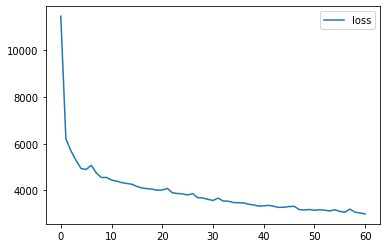

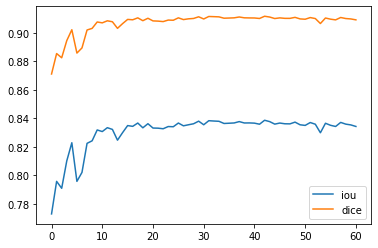

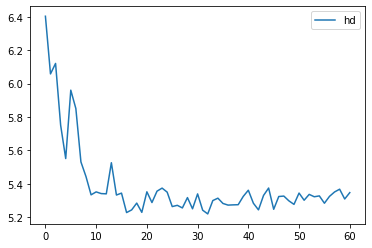

In [ ]:
import argparse
import os
import logging
import torch
import time
import math
import random
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import autograd, optim

from torchvision.transforms import transforms

# parameters should be set in args
# args = getArgs()
# logging = getLog(args)

# Set the random seed for reproducible experiments
# random.seed(230)
# torch.cuda.manual_seed(230) if params.cuda else torch.manual_seed(230)


###############
# Data Loader #
###############

 
# train_loader = get_data(batch_size=args.batch_size, type='train')
# val_loader = get_data(batch_size=args.batch_size, type='val')

# this temporary data is for construct assist net architecture
temp_dl = torch.FloatTensor(torch.randn(1, 3, 256, 256))


print("############################################")
print("now using "+ str(args.distill_version) + " to compress teacher model")
print("teacher model is " + args.teacher_model)
print("student model is Unet16")


###################
# Teacher Network #
###################
if (args.teacher_model == 'UNet'):
    teacher_model = UNet(3,1)
elif (args.teacher_model == 'NestedUNet'):
    teacher_model = NestedUNet(0,3,1)
elif (args.teacher_model == 'R2U_Net'):
    teacher_model = R2U_Net()
else:
    raise NotImplementedError(args.teacher_model)


# this fake output just for create assist net
teacher_model.eval()
teacher_out = teacher_model(temp_dl)



###################
# Student Network #
###################

trainable_module_list = nn.ModuleList([])

student_model = UNet_16(3, 1)

trainable_module_list.append(student_model)
student_model.eval()
student_out = student_model(temp_dl)


##################
# Assist Network #
##################

if (args.distill_version == 'kd'):
        t_s_map_dict = {'teacher': 'logits', 'student': 'logits'}
        assist_model = KD(teacher_out, student_out, t_s_map_dict)
        logging.info('Now using kd Assist Network')
elif (args.distill_version == 'fitnet'):
        t_s_map_dict = {'teacher': 'feas', 'student': 'feas'}
        assist_model = FitnetConvReg(teacher_out, student_out, t_s_map_dict)
        logging.info('Now using fitnet Assist Network')
elif (args.distill_version == 'at'):
        t_s_map_dict = {'teacher': 'logits', 'student': 'logits'}
        assist_model = AT(teacher_out, student_out, t_s_map_dict)
        logging.info('Now using at Assist Network')
elif (args.distill_version == 'kc'):
        t_s_map_dict = {'teacher': 'feas', 'student': 'feas'}
        assist_model = KC(teacher_out, student_out, t_s_map_dict)
        logging.info('Now using KC Assist Network')
else:
        raise NotImplementedError(args.distill_version)

assist_model = assist_model.cuda()
trainable_module_list.append(assist_model)
# assist_out = assist_model(teacher_out, student_out, t_s_map_dict)



####################
#    Loss   #
####################

# test assist nets
if (args.distill_version == 'kd'):
    # loss_fn = Loss.loss_fn_kd
    loss_fn = loss_fn_kd
elif (args.distill_version == 'fitnet'):
    # loss_fn = Loss.loss_fn_fitnet
    loss_fn = loss_fn_fitnet
elif (args.distill_version == 'at'):
    # loss_fn = Loss.loss_fn_at
    loss_fn = loss_fn_at
elif (args.distill_version == 'kc'):
    # loss_fn = Loss.loss_fn_KC
    loss_fn = loss_fn_KC


###################
#    Optimizer    #
###################

optimizer = optim.Adam(trainable_module_list.parameters(), lr=args.learning_rate)


##############################
#  load teacher model  #
##############################

# teacher_model.load_state_dict(torch.load(r'./saved_model/'+'_'+str(args.batch_size)+'_'+str(args.epoch)+'.pth', map_location='cpu'))
teacher_model.load_state_dict(torch.load(r'./saved_model/'+ str(args.weight_name)+'.pth', map_location='cpu'))

######################
# Run Train and Eval #
######################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('**************************')
print('\nepoch:%s,\nbatch size:%s\n' % \
      (args.epoch, args.batch_size))
logging.info('\n=======\n\nepoch:%s,\nbatch size:%s\n========' % \
      (args.epoch, args.batch_size))
print('**************************')

student_model.cuda()

train_kd(student_model, assist_model, teacher_model, t_s_map_dict, loss_fn, optimizer, train_loader, val_loader, args)

iou=0.8784734010696411,dice=0.9353057026994276
iou=0.8371959328651428,dice=0.9113845227512416
iou=0.856137216091156,dice=0.9224934567563716
iou=0.7898309230804443,dice=0.8825760680795253
iou=0.8765825629234314,dice=0.9342329102879693
iou=0.8509359359741211,dice=0.9194656193546131
iou=0.8705570697784424,dice=0.9307998100703551
iou=0.8212264776229858,dice=0.9018389750733634
iou=0.8346227407455444,dice=0.9098576039153055
iou=0.6799982786178589,dice=0.8095225883519552
iou=0.8160680532455444,dice=0.8987196318331069
iou=0.8404237031936646,dice=0.9132936801049026
iou=0.8473250865936279,dice=0.9173535635369123
iou=0.8344430923461914,dice=0.9097508673494514
iou=0.8276589512825012,dice=0.9057039165812988
iou=0.8530570864677429,dice=0.9207024187539559
iou=0.8545112013816833,dice=0.9215487555588728
iou=0.871177077293396,dice=0.9311540900596259
iou=0.8384637236595154,dice=0.9121352251766931
iou=0.8531309962272644,dice=0.9207454866242686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iou=0.8218816518783569,dice=0.9022338715463427
iou=0.8697145581245422,dice=0.9303180026184249
iou=0.86529541015625,dice=0.9277837364379462
iou=0.8772192597389221,dice=0.9345943456218665
iou=0.873073935508728,dice=0.9322364584036786
iou=0.8461348414421082,dice=0.9166555159463301
iou=0.8300191760063171,dice=0.907115292248536
iou=0.8657870292663574,dice=0.9280662799126675
iou=0.837536096572876,dice=0.9115860227347753
iou=0.8154194951057434,dice=0.8983262378879813
iou=0.8593909740447998,dice=0.9243789706943526
iou=0.8685489296913147,dice=0.9296507622029323
iou=0.8503218293190002,dice=0.9191069780688579
iou=0.8709176182746887,dice=0.9310058417428203
iou=0.8546241521835327,dice=0.9216144648737327
iou=0.8402641415596008,dice=0.9131995353911079
iou=0.8463123440742493,dice=0.9167596457068481
iou=0.867038369178772,dice=0.9287847209558256
iou=0.8430505990982056,dice=0.9148425919983374
iou=0.8074034452438354,dice=0.8934402960330787
iou=0.8477193713188171,dice=0.9175845218136967
iou=0.7120370864868

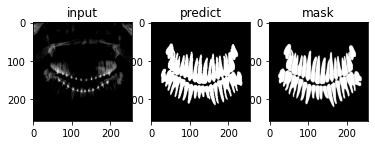

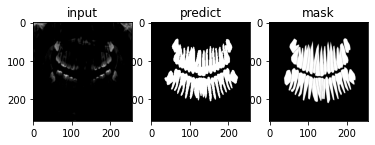

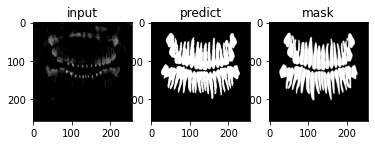

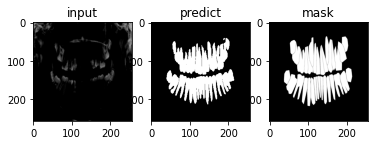

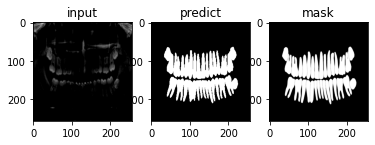

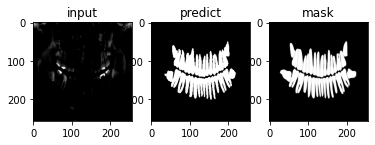

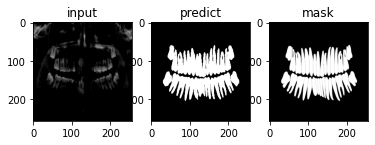

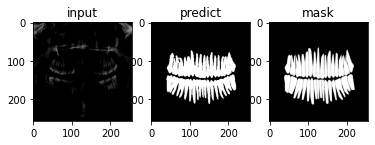

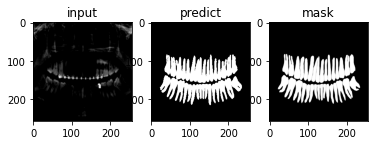

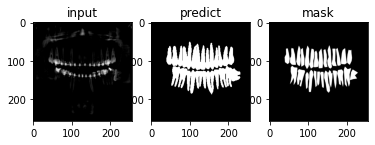

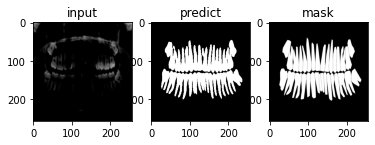

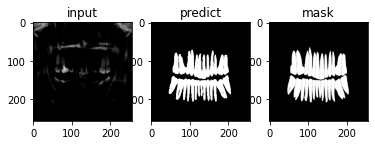

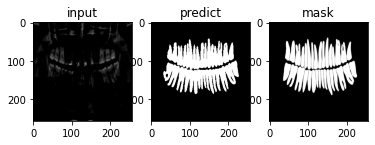

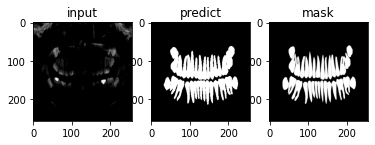

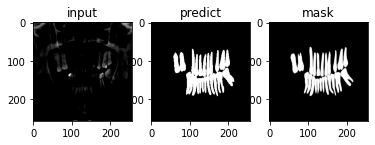

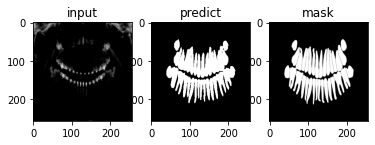

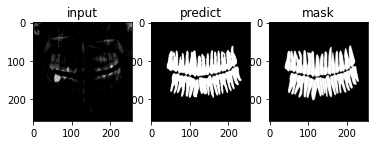

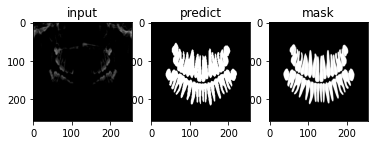

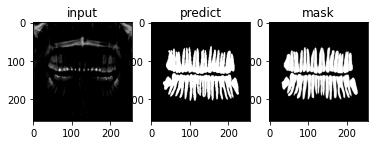

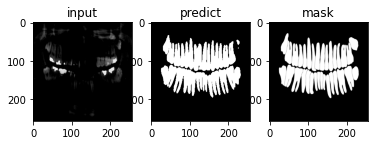

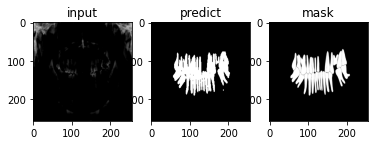

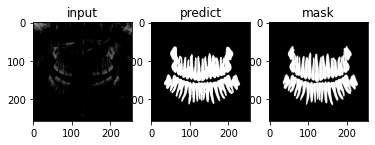

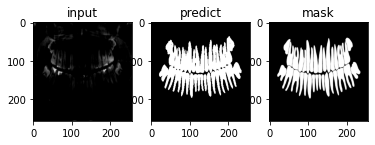

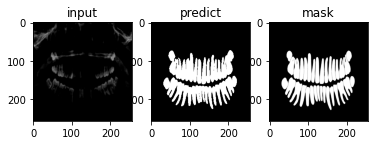

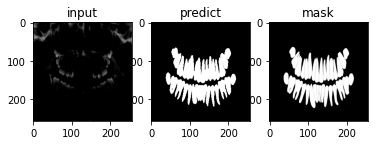

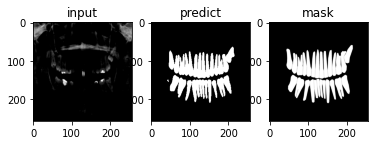

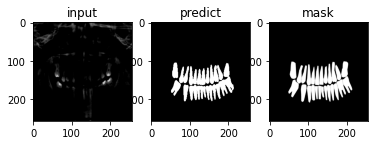

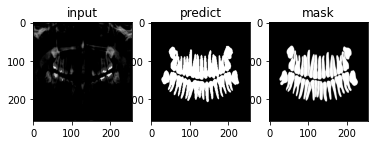

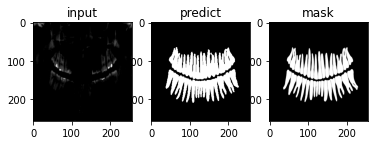

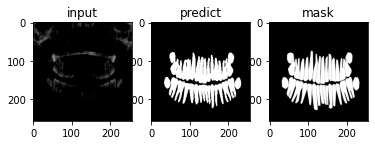

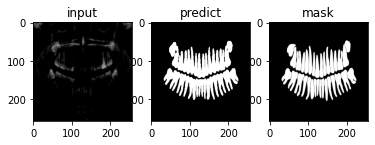

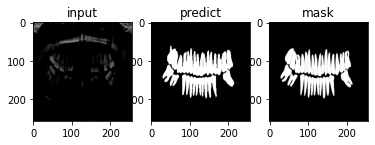

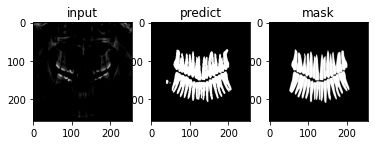

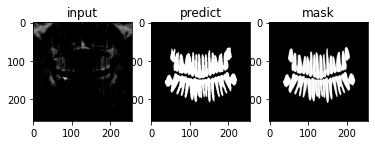

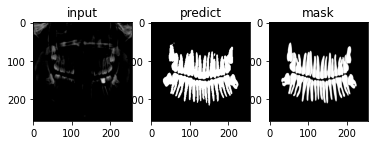

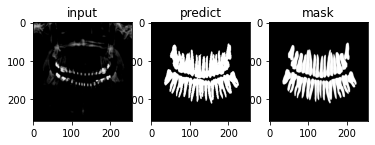

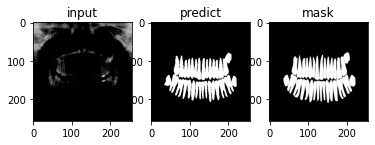

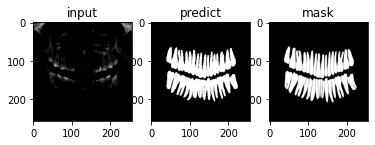

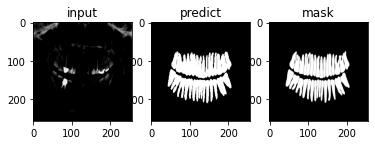

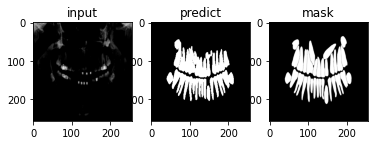

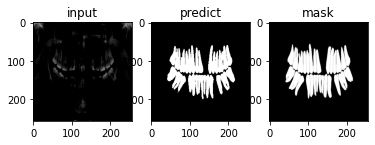

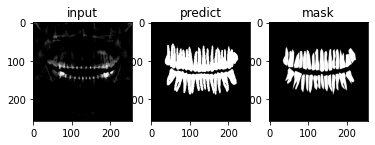

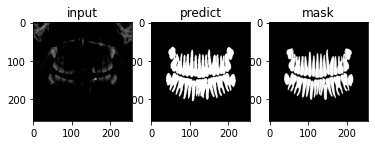

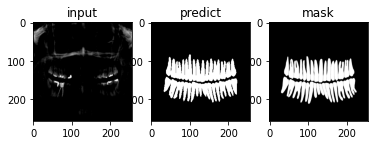

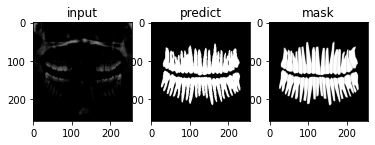

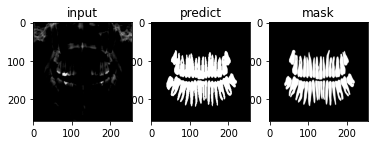

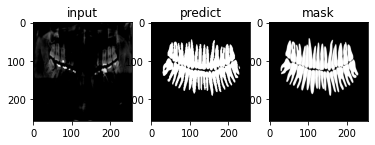

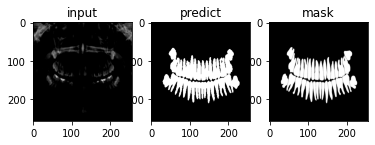

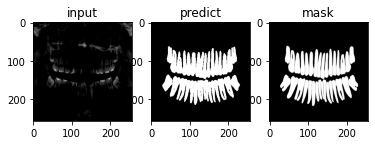

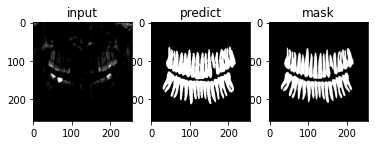

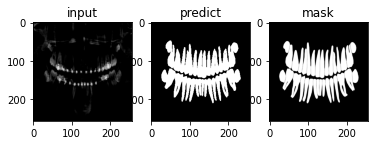

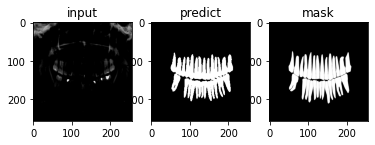

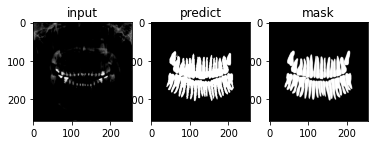

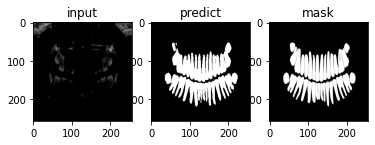

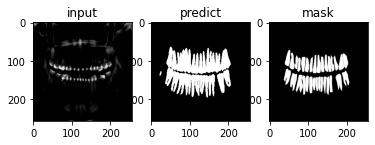

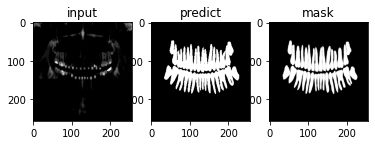

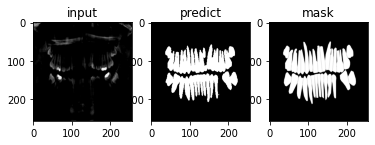

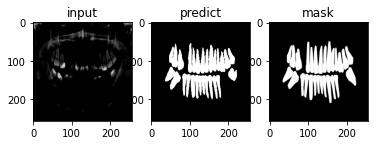

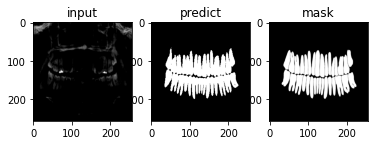

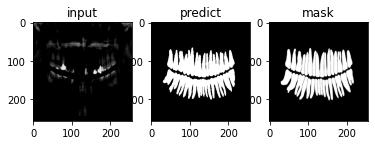

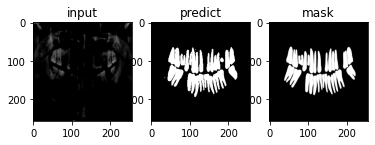

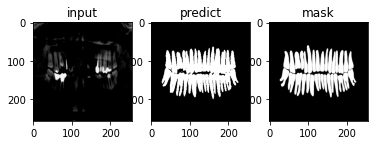

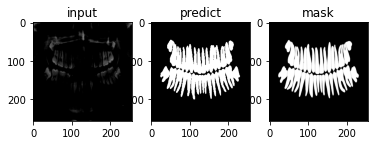

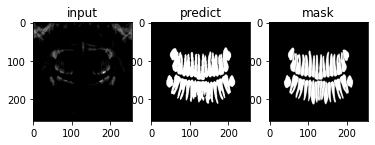

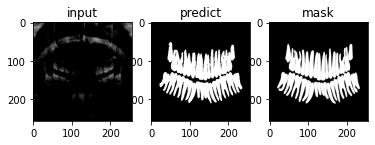

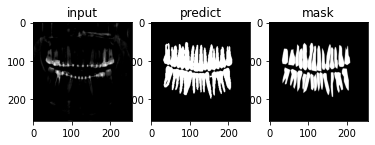

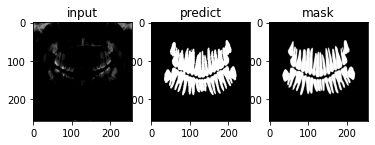

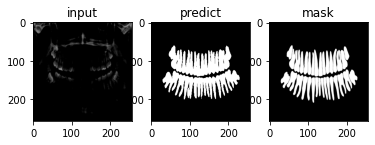

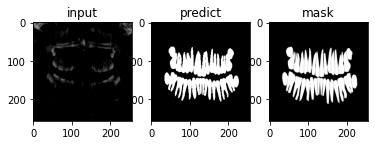

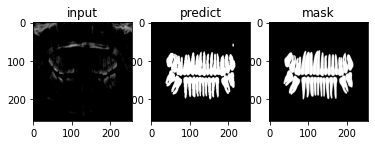

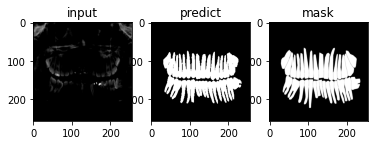

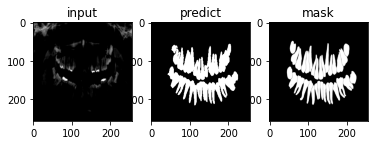

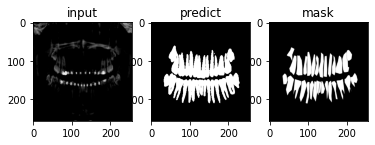

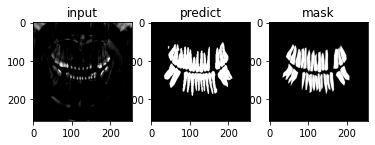

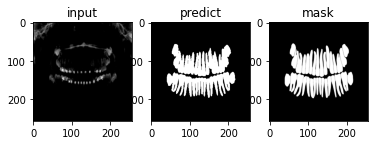

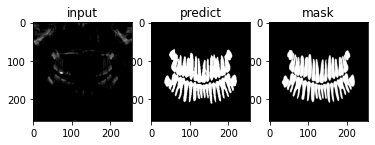

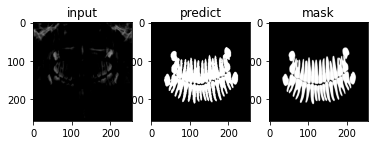

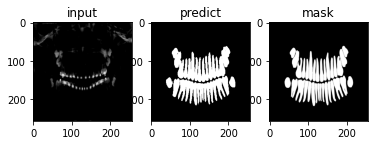

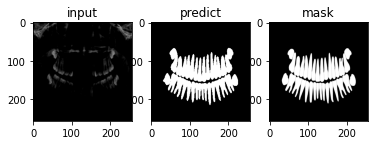

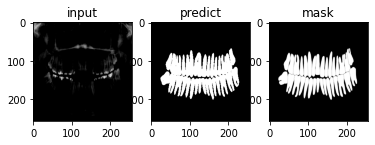

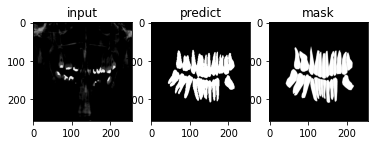

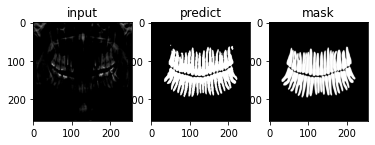

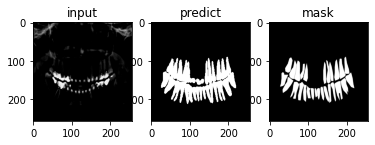

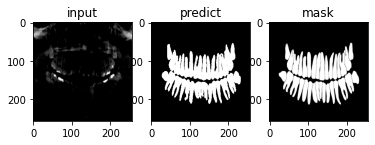

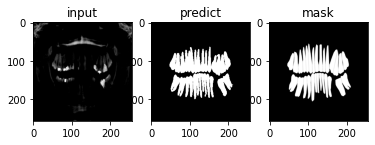

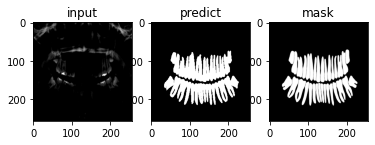

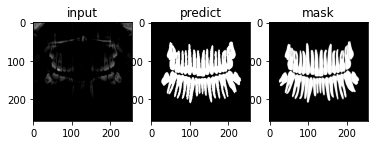

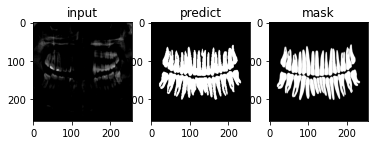

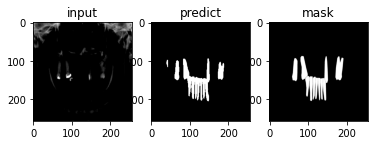

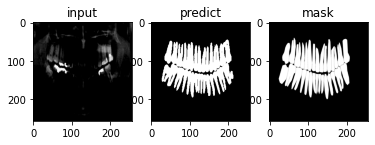

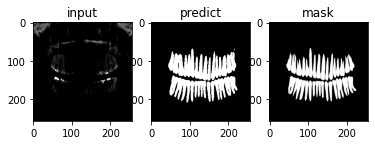

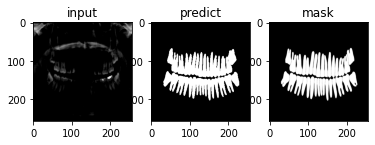

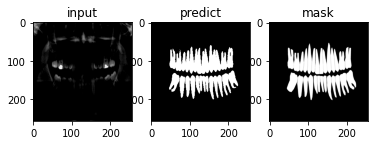

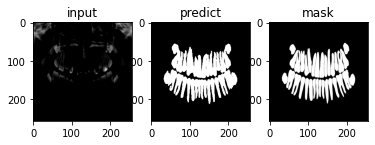

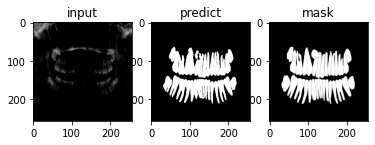

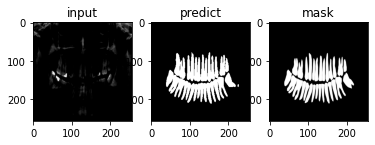

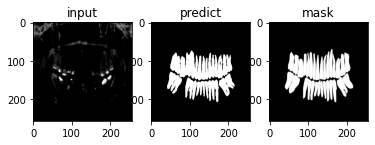

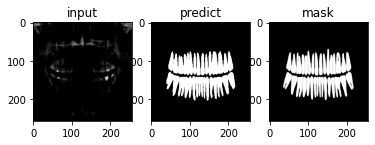

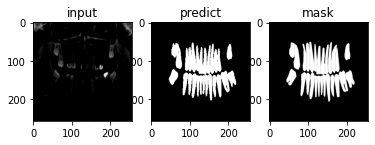

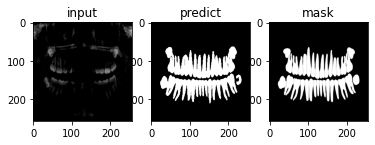

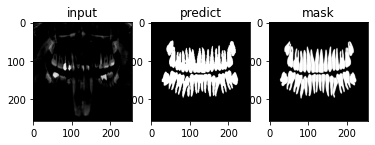

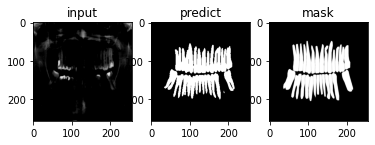

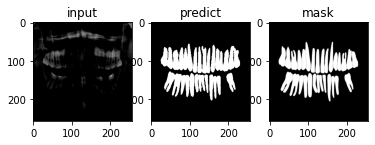

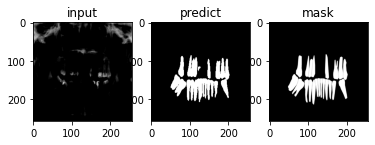

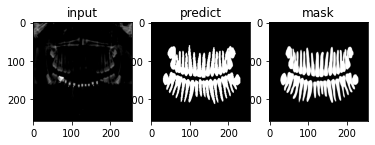

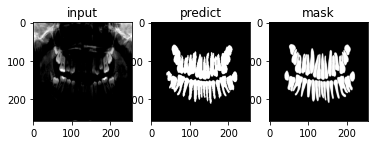

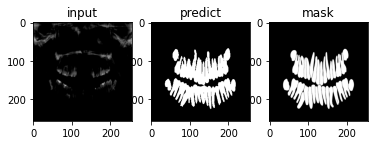

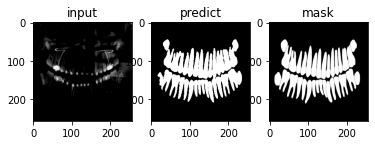

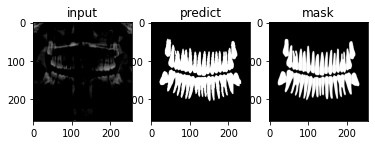

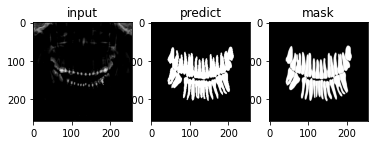

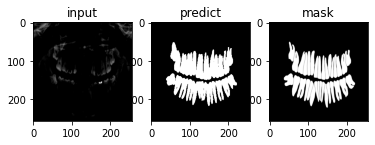

In [ ]:
# test student network

student = UNet_16(3, 1)
student.cuda()

# args = getArgs()
# logging = getLog(args)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# val_loader = get_data(batch_size=args.batch_size, type='val')

test_kd(val_loader, student, save_predict=True)